# RateMyProfessors Data Analysis

## Introduction

When I was in college (last month lol), it was crucial that I had a good professor to succeed in the class. Unlike many of my friends who could easily self-study any class, I was that one kid who was at every office hours asking questions from start to finish. One tool that I used throughout my college career was the review site called RateMyProfessors (RMP). Here, I could go through sometimes hundreds of reviews on almost every professor and use that information to schedule myself optimally. For the most part, RMP did a pretty good job at giving an overall rundown of what to expect from a professor. In this data analysis, I want to take a deeper look into reviews on the website and what students look for in a professor.

In [127]:
import requests
from bs4 import BeautifulSoup
import lxml.html as lx
from PIL import Image
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import scipy.stats as stats
import missingno
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

## Part 1: Data Collection

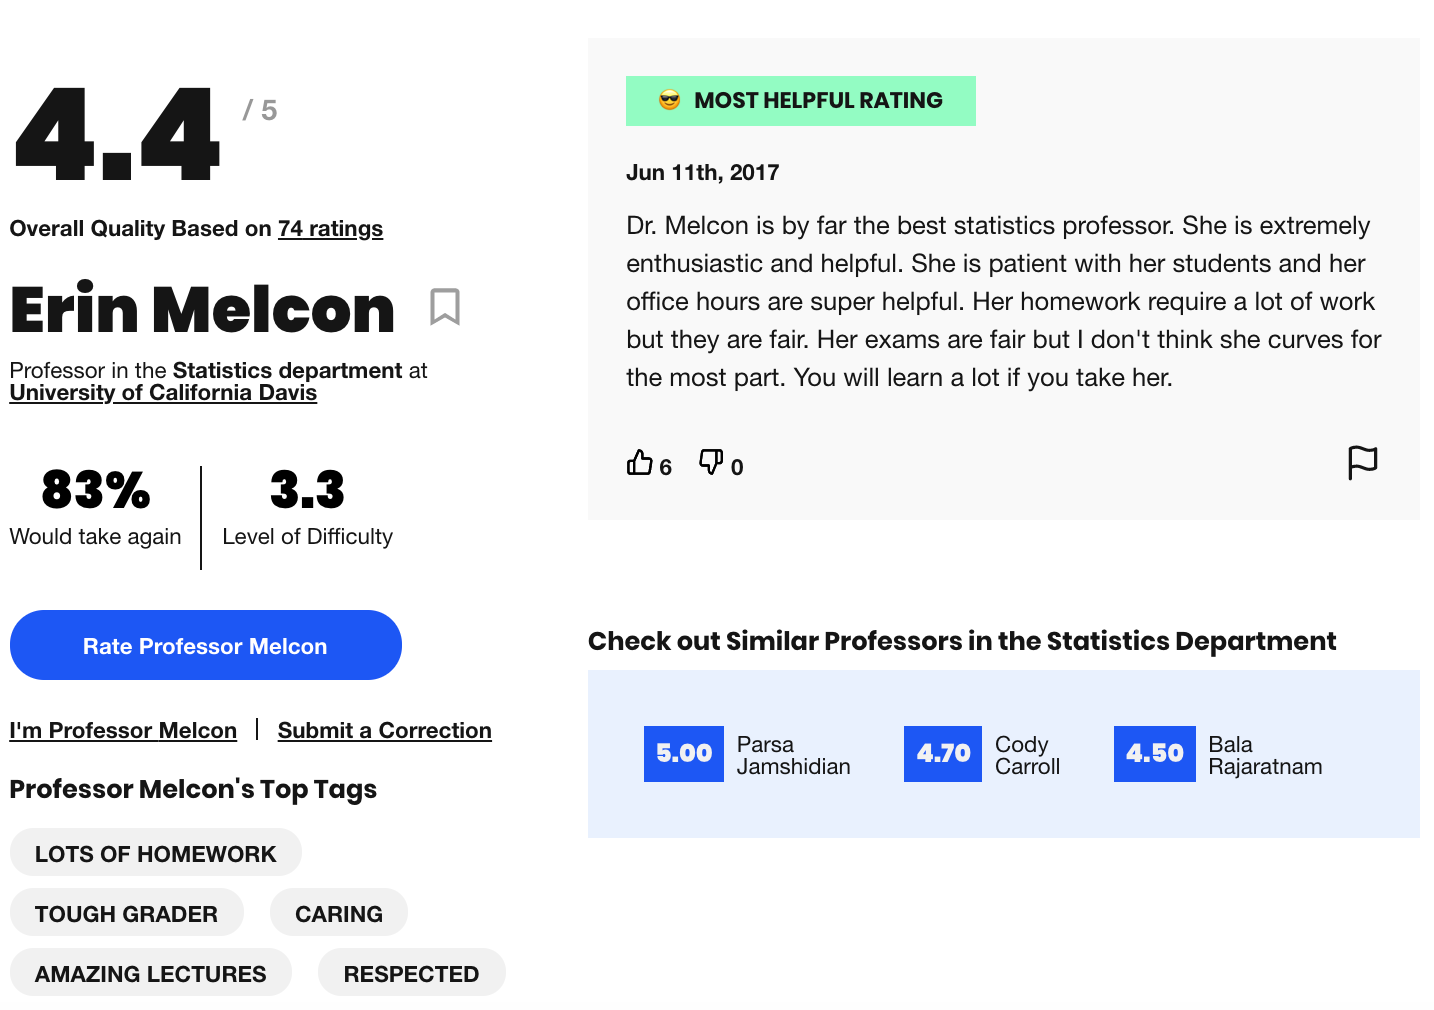

In [2]:
Image.open('/Users/tylerchang/Desktop/ratemyprof/images/erin.png')

As you can see, there is *a lot of information* packed into a professor's page. Unfortunately, RMP does not provide an API nor has anyone (to my knowledge) ever open sourced the data, so I had the daunting task of scraping the data manually. I broke the scraping process into two parts:

* Get the information on **each of the professors**

* Get the information on **each of the reviews**

Without getting into too much detail of the code, I used the `BeautifulSoup` library to extract specific parts from a given professor's url.

In [3]:
def getProfs(urls):
    
    '''
    This function will grab some basic information about a professor (i.e quality, difficulty, etc.)
    ** EXCLUDING THE REVIEWS **
    '''
    headers = {"User-Agent":
               "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.122 Safari/537.36"}
    
    name_list = []
    quality_list = []
    difficulty_list = []
    take_again_list = []
    num_ratings_list = []
    top_tags_list = []
    
    for url in urls:
        page = requests.get(url, headers = headers)
        java_soup = BeautifulSoup(page.content, "html.parser")
        soup = BeautifulSoup(java_soup.prettify(), "html.parser")
        
        name = soup.find("div", {'class': "NameTitle__Name-dowf0z-0 jeLOXk"}).get_text(strip = True)
    
        quality = float(soup.find("div", {'class': "RatingValue__Numerator-qw8sqy-2 gxuTRq"}).get_text(strip = True))
        
        difficulty_takeAgain = soup.find_all("div", {'class': "FeedbackItem__FeedbackNumber-uof32n-1 bGrrmf"},text=True)
        if len(difficulty_takeAgain) == 1:
            difficulty = float(soup.find_all("div", {'class': "FeedbackItem__FeedbackNumber-uof32n-1 bGrrmf"},text=True)[0].text.strip())
            take_again = np.NaN
        else:
            difficulty = float(soup.find_all("div", {'class': "FeedbackItem__FeedbackNumber-uof32n-1 bGrrmf"},text=True)[1].text.strip())
            take_again = soup.find_all("div", {'class': "FeedbackItem__FeedbackNumber-uof32n-1 bGrrmf"},text=True)[0].text.strip()
    
        num_ratings = soup.find("a", {'href': "#ratingsList"}).get_text(strip = True)
        num_ratings = float(re.findall(r'\d+', num_ratings)[0])
                                           
        full_tags = soup.find_all("span", {'class': "Tag-bs9vf4-0 jqEvsD"}, text = True)
        top_tags = []
        
        if len(full_tags) == 0:
            pass
        else:    
            for i in range(0,5):
                top_tag = full_tags[i].text.strip()
                top_tags.append(top_tag)
    
        name_list.append(name)
        quality_list.append(quality)
        difficulty_list.append(difficulty)
        take_again_list.append(take_again)
        num_ratings_list.append(num_ratings)
        top_tags_list.append(top_tags)
        
    df = pd.DataFrame({'name': name_list, 'quality':quality_list, 'difficulty':difficulty_list,
                      'take_again':take_again_list, 'num_ratings': num_ratings_list, 'top_tags':top_tags_list})
    return df

In [4]:
def getReviews(urls):
    
    '''
    This function will scrape the data from each of the reviews given a list of urls
    '''
    headers = {"User-Agent":
               "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.122 Safari/537.36"}
    
    pol = lambda x: TextBlob(x).sentiment.polarity
    sub = lambda x: TextBlob(x).sentiment.subjectivity
    
    total_text = []
    total_fields = []
    total_quality = []
    total_difficulty = []
    total_name = []
    
    for url in urls:
        
        # Recreate the HTML
        page = requests.get(url, headers = headers)
        java_soup = BeautifulSoup(page.content, "html.parser")
        soup = BeautifulSoup(java_soup.prettify(), "html.parser")
        
             
        # Find the reviews in the HTML
        reviews = soup.find_all(id = 'ratingsList')[0]

        for review in reviews.find_all('li'):
            
            # Check if the <li> is actually an ad
            first_child = review.findChildren()[0].attrs['class']
            first_child = first_child[0] + ' ' + first_child[1]
            if first_child == 'RatingsList__AdWrapper-hn9one-0 ifQcbR':
                continue
            
            # Find the name of the professor 
            name = soup.find("div", {'class': "NameTitle__Name-dowf0z-0 jeLOXk"}).get_text(strip = True)
            name = re.findall('[A-Z][a-z]*', name) 
            name = name[0] + ' ' + name[1]
                
            # Find all of the fields (i.e. Attendance, Grade, etc.)
            fields = review.find_all("div", {'class': "CourseMeta__StyledCourseMeta-x344ms-0 dgqjDO"})
            fields_list = []
            all_fields = fields[0].find_all("div", {'class': "MetaItem__StyledMetaItem-y0ixml-0 ezVUqy"})       
            for field in all_fields:
                response = field.get_text(strip = True)
                fields_list.append(response)

            # Find the text of the review    
            text = review.find("div", {'class': "Comments__StyledComments-dzzyvm-0 dvnRbr"}).get_text(strip = True)

            # Find the quality rating of the review
            # Different 'color' ratings (Awesome, okay, awful) have different tags
            colors = ['iZENup', 'kMhQwk', 'fBPVTR']
            quality = None
            for color in colors:
                query = 'RatingValues__RatingValue-sc-6dc747-3 ' + color
                quality = review.find("div", {'class': query})
                if quality:
                    quality = float(quality.get_text(strip = True))
                    break
            
            # Find difficulty
            difficulty = float(review.find("div", {'class': "RatingValues__RatingValue-sc-6dc747-3 ieQwTJ"}).get_text(strip = True))
            
            total_name.append(name)
            total_text.append(text)
            total_fields.append(fields_list)
            total_quality.append(quality)   
            total_difficulty.append(difficulty)
                
    df = pd.DataFrame({'name': total_name,
                       'text': total_text,
                       'fields': total_fields,
                       'Attendance':['']*len(total_text),
                        'Grade': ['']*len(total_text),
                       'Online Class':['']*len(total_text),
                       'Textbook': ['']*len(total_text),
                       'Would Take Again': ['']*len(total_text),
                       'For Credit': ['']*len(total_text),
                       'quality':total_quality,
                       'difficulty': total_difficulty
                      })
    
    dic = {'Attendance': 3, 'Grade': 4, 'Online Class': 5, 'Textbook': 6, 'Would Take Again':7, 'For Credit':8} 
    
    # Fill the fields cells
    for index, row in df.iterrows():
        for field in row['fields']:
            field_name = field.split(':')[0]
            field_response = field.split(':')[1]
            colidx= dic[field_name]
            df.iloc[index, colidx] = field_response
    
    # Find the sentiment of the text 
    df['polarity'] = df['text'].apply(pol)
    df['subjectivity'] = df['text'].apply(sub)
    
    # Find length of the text of a review
    df['character_length'] = [len(x) for x in df.text]
    
    
    df = df.replace(r'^\s*$', np.nan, regex=True)
    df = df.drop(columns = ['fields'])
    return df

In [5]:
def getText(url):
    
    '''
    This function will get the reviews of a given professor, and combine them into a SINGLE CORPUS
    '''
  
    headers = {"User-Agent":
               "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.122 Safari/537.36"}
    page = requests.get(url, headers = headers)
    java_soup = BeautifulSoup(page.content, "html.parser")
    soup = BeautifulSoup(java_soup.prettify(), "html.parser")
    
    reviews = soup.find_all("div", {'class': "Comments__StyledComments-dzzyvm-0 dvnRbr"},text=True)
    reviews_list = []
    for i in range(0, len(reviews)):
        text = reviews[i].text.strip()
        reviews_list.append(text)
        
    corpus = ' '.join(reviews_list)
        
    return corpus

## Part 2: Exploratory Data Analysis

In this section I will be trying to answer a few different questions. To keep things simple I will mainly be restricting the EDA to professors from my alma mater, UC Davis.

### Q1: Were my old professors rated accurately?

In this section, I will personally evaluate how well my old professors were rated by looking at their recent reviews. 

In [6]:
old_profs = ['https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1607095',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=410280',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=277017',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2151901',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=91545',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2423050',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1984361',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2134448',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2173631',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=661326',
            'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2341907',
        'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1784758',
        'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1982339',
        'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=141845',
        'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2188504',
        'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=149186',
        'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=58847'
       ]

names = ['melcon','hsieh','jiang','li','drake','namdari','ulle','balasubramanian','whitener',
         'wilson', 'price', 'stimel', 'muehlegger', 'cameron', 'carvajal','bonanno','kouba']

In [7]:
corpus_list = [getText(prof) for prof in old_profs]
corpus_df = pd.DataFrame({'name':names, 'corpus':corpus_list})
corpus_df.head()

,name,corpus
0,melcon,Dr. Melcon is by far the best statistics profe...
1,hsieh,Allowed a cheat sheet for exams. No curve. I n...
2,jiang,Very easy grader. Doesn't give too much feedb...
3,li,The most excellent prof. I have ever seen. He ...
4,drake,This was my first stats class. Professor Drake...


What we have now is a dataframe of each professor and there most recent comments on RMP! Let's take a closer look at one of these `corpus` cells.

In [8]:
corpus_df.corpus[0]

'Dr. Melcon is by far the best statistics professor. She is extremely enthusiastic and helpful. She is patient with her students and her office hours are super helpful. Her homework require a lot of work but they are fair. Her exams are fair but I don\'t think she curves for the most part. You will learn a lot if you take her. Still one of my fave profs! Melcon is a really good lecturer, which is an underrated skill. She writes everything on the board & can break down the most complicated statistical theory. She even gives input from her industry experience about which tests are better &/or used more often in the industry, & what we might expect in being statisticians. Not a bad lecture, but it\'s the first time I met a professor who\'s picky about wording in the exam. By the way, be careful with her project since she might take points of for something she didn\'t ask. Fantastic Professor. Really appreciated her great lectures and how willing she was to help students. Melcon gives you 

As you can see, we have an huge string of words for a single professor. The `getText()` function pulls the most recent (maximum 20) reviews from a professor's RMP, and combines each of the reviews into **a single string (corpus)**. Why?

In order to evaluate how well an old professor is being evaluated, I want to look for words/phrases (tokens) that are commonly found in their reviews. How will we do that? We'll essentially be **counting the frequency of words/phrases** using `CountVectorizer()` within a professor's corpus of reviews.

Before counting, we first need to **clean up the corpus** to make sure tokens are properly accounted for. By cleaning the text, this will ensure that tokens that only differ by punctuation, parts of speech, etc.. will be counted properly.

**Note:** I only did a very basic cleaning, but many other methods (stemming, tokenization, etc..) could have been used for this step as well.

In [9]:
def clean_text(text):
    # Make everything lowercase
    text = text.lower()
    # Takes out punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Takes out digits
    text = re.sub('\w*\d\w*', '', text)
    return text

cleaner = lambda x: clean_text(x)

clean_df = pd.DataFrame({'name':names, 'clean_corpus':corpus_df.corpus.apply(cleaner)})
clean_df.head()

,name,clean_corpus
0,melcon,dr melcon is by far the best statistics profes...
1,hsieh,allowed a cheat sheet for exams no curve i nev...
2,jiang,very easy grader doesnt give too much feedbac...
3,li,the most excellent prof i have ever seen he is...
4,drake,this was my first stats class professor drake ...


In [10]:
clean_df.clean_corpus[0]

'dr melcon is by far the best statistics professor she is extremely enthusiastic and helpful she is patient with her students and her office hours are super helpful her homework require a lot of work but they are fair her exams are fair but i dont think she curves for the most part you will learn a lot if you take her still one of my fave profs melcon is a really good lecturer which is an underrated skill she writes everything on the board  can break down the most complicated statistical theory she even gives input from her industry experience about which tests are better or used more often in the industry  what we might expect in being statisticians not a bad lecture but its the first time i met a professor whos picky about wording in the exam by the way be careful with her project since she might take points of for something she didnt ask fantastic professor really appreciated her great lectures and how willing she was to help students melcon gives you all the resources you need to g

Now that we've done a first round of cleaning to the text, we can start counting with `CountVectorizer()`

In [11]:
cv = CountVectorizer(stop_words = 'english', ngram_range=(1,2))
data_cv = cv.fit_transform(clean_df.clean_corpus)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm = data_dtm.transpose()
data_dtm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
abilities,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
abilities interested,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
ability,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
ability enjoy,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
ability teach,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


What we created here is a (transposed) *document term matrix*. Here, **each column represents a professor, each row is a word or pair of words that was found throughout *all* of the professors reviews, and each cell value corresponds to the how many times that token was found in a professor's reviews.** 

**Note:** Another minor cleaning/pre-processing step taken here was the **removal of English stop words**. These are words like "a", "is", "in", and other words that serve no functional value to the analysis.

In [12]:
top_dict = {}
for prof in data_dtm.columns:
    top = data_dtm[prof].sort_values(ascending = False).head(30)
    top_dict[prof] = list(zip(top.index, top.values))

for prof, top_words in top_dict.items():
    print(prof)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

0
class, homework, notes, tests, lecture, helpful, melcon, professor, need, stats, make, hw, online, lecture notes
---
1
exams, professor, good, ask, ta, lectures, worst, hw, really, homework, difficult, lecture, avoid, guy
---
2
class, easy, midterm, final, homework, good, projects, weekly, professor, helpful, notes, lecture, examples, lot
---
3
class, students, professor, final, statistics, lectures, notes, homework, dont, know, prof, make, ive, li
---
4
class, lectures, drake, professor, shes, help, nice, teach, homework, exams, easy, tophat, teaching, professor drake
---
5
notes, class, namdari, practice, homework, midterms, professor, difficult, tests, lecture, quizzes, exams, hard, professors
---
6
class, hours, homework, students, great, office hours, helpful, questions, grading, project, stuff, lot, office, student
---
7
hard, really, course, hard homework, homework, clear, really hard, grade, work, week, exams, felt, says, thereof class
---
8
lectures, tests, professor, whiten

Here are the top tokens found with each of my old professors. As a next step, we should actually do an **extra round of cleaning** by removing more words. Words like "notes", "class", the professor's name, do not provide much insight to the type of professor he/she is. Let's get rid of these words too.

In [13]:
more_stopwords = names + ['class','professor', 'lectures', 'homework', 'exams', 'student',
                          'lecture', 'final','notes', 'really', 'lot','tests', 'questions','students',
                         'statistics', 'stats', 'economics', 'econ', 'statistic', 'got','way', 'math',
                         'grade', 'graded','hw','midterm','test','make', 'tas', 'ucdavis','met','person']

Instead of redoing the process of recreating the document-term matrix, I'll just take a shortcut to visualizing our results with some WordClouds.

In [14]:
stop_words = text.ENGLISH_STOP_WORDS.union(more_stopwords)

Text(0.5, 1.0, 'Carvajal (2)')

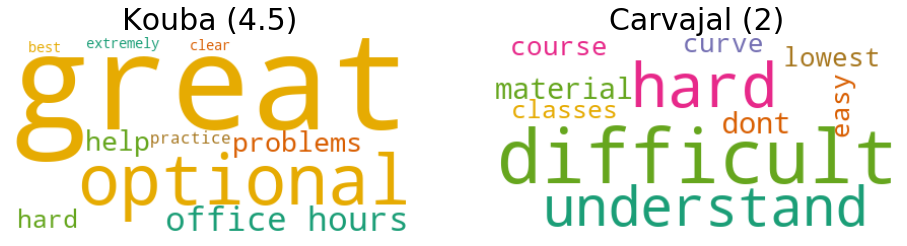

In [15]:
wc = WordCloud(stopwords = stop_words, background_color = 'white', colormap = 'Dark2',
              max_font_size = 150, random_state = 42, max_words=10)

plt.rcParams['figure.figsize'] = [16,6]

plt.subplot(1, 2, 1)
wc.generate(clean_df.clean_corpus[16])
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")
plt.title('Kouba (4.5)', fontsize= 30)

plt.subplot(1, 2, 2)
wc.generate(clean_df.clean_corpus[14])
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")
plt.title('Carvajal (2)', fontsize= 30)

Personally, I think these WordClouds are pretty accurate! Professor Kouba was honestly the best all-around professor I've had in college and his class was really fair if you put the work in. I got my worst grade (to be left unknown) with Professor Carvajal, and I'll just say that this his WordCloud is spot on.

### Q2: What do students look for in a "good" professor?

In the last section we saw some tokens commonly used when describing some of my old professors. Now, I want to look at some words that are used when describing a "good" professor. Instead of limiting the search to just my past professors, we will now expand the search to **all active UC Davis professors in the Statistics *and* Economics Departments.**

In [16]:
stats_profs = ['anderes', 'aue', 'balasubramanian', 'burman', 'chen_hao', 'chen_shizhe',
              'drake', 'farne','hsieh', 'jiang', 'lai', 'le', 'lee', 'li', 'lopes','paul', 'peng',
              'polonik', 'rajaratnam', 'sharpnack', 'lang', 'wang', 'farris', 'namdari', 'whitener']

stats_urls = ['https://www.ratemyprofessors.com/ShowRatings.jsp?tid=900366',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1286077',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2134448',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=346995',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1842882',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2457226',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=91545',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2520231',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=410280',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=277017',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1821794',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2292538',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1452013',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2151901',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2047752',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=779324',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=781562',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=155233',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2520779',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2157673',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=375775',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=778384',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1808811',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2423050',
              'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2173631']

econ_profs = ['bergin', 'boik', 'bonanno', 'bushnell', 'cameron', 'caramp', 'carrell', 'carvajal',
             'chakraborty', 'clark', 'cloyne', 'eriksson', 'geromichalos', 'jorda', 'meissner', 'moreira',
             'muehlegger', 'page', 'perez', 'peri', 'rapson', 'russ', 'schipper', 'shen', 'simonovska',
             'singh', 'singhal', 'stearns', 'stimel', 'swenson', 'wilson' , 'woo']

econ_urls = ['https://www.ratemyprofessors.com/ShowRatings.jsp?tid=148345',
            'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1991530',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=149186',
            'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1646888',
            'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=141845',
            'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2347648',
            'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1081387',
            'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2188504',
            'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2340892',
            'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=78576',
            'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2298029',
            'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2112691',
            'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1520585',
            'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=331422',
            'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1109461',
            'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2369334',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1982339',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=316253',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2340919',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=231904',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1257738',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=549377',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=806589',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1696895',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1384023',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2320741',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2266968',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2351502',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1784758',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=162260',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=661326',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=392141'
            ]
profs = stats_profs + econ_profs
urls = stats_urls + econ_urls

In [17]:
econ_stats_df = getProfs(urls)
econ_stats_df.head()

,name,quality,difficulty,take_again,num_ratings,top_tags
0,EthanAnderes,4.3,2.6,100%,76.0,"[Caring, Respected, Clear grading criteria, Am..."
1,AlexanderAue,3.0,3.1,24%,46.0,"[Tough grader, Tests are tough, Test heavy, Sk..."
2,KrishnakumarBalasubramanian,2.8,4.2,NaN,5.0,"[Lots of homework, Tough grader, Get ready to ..."
3,PrabirBurman,3.3,3.0,80%,23.0,"[Group projects, Lots of homework, Respected, ..."
4,HaoChen,2.7,3.4,28%,56.0,"[Tough grader, Lots of homework, Would take ag..."


Now that we have the data on the professors, we should consider filtering out some of them. Notice how the professor on the third row *only has 5 ratings*. Let's quickly check the **distribution of number of ratings**.

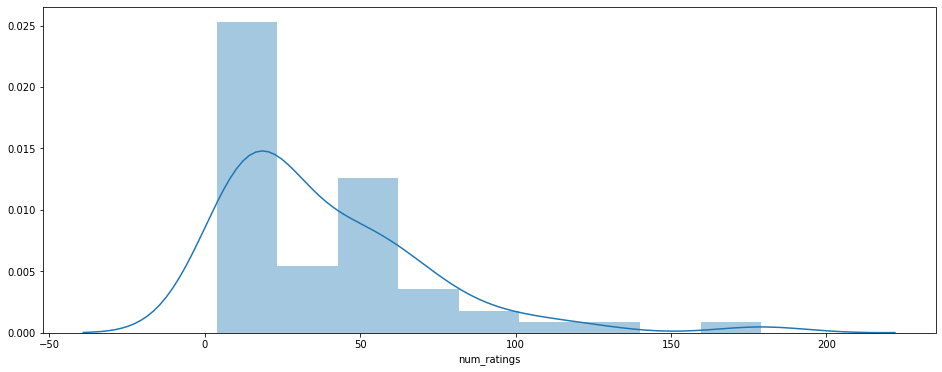

In [18]:
sns.distplot(econ_stats_df.num_ratings)

It looks like the distribution of number of ratings is *heavily skewed left*. That is, **most professors have a realtively low number of reviews**. What do we do about this?

We don't want to use professors that have a little number of reviews because we want the representation of the professor to be as accurate as possible. Let's get rid of the professors that have **a number of reviews less than the median value**.

In [19]:
econ_stats_df = econ_stats_df[econ_stats_df.num_ratings >= econ_stats_df.num_ratings.median()]
econ_stats_df = econ_stats_df.reset_index(drop = True)
econ_stats_df.head()

,name,quality,difficulty,take_again,num_ratings,top_tags
0,EthanAnderes,4.3,2.6,100%,76.0,"[Caring, Respected, Clear grading criteria, Am..."
1,AlexanderAue,3.0,3.1,24%,46.0,"[Tough grader, Tests are tough, Test heavy, Sk..."
2,HaoChen,2.7,3.4,28%,56.0,"[Tough grader, Lots of homework, Would take ag..."
3,ChristianaDrake,2.0,3.2,29%,179.0,"[Lots of homework, Group projects, Participati..."
4,FushingHsieh,1.8,3.9,100%,27.0,"[Tests? Not many, Lots of homework, Hilarious,..."


The next step is to determine what makes a professor "good." One way we can define "good" is by looking at the `quality` feature. Let's check out how this column is distributed.

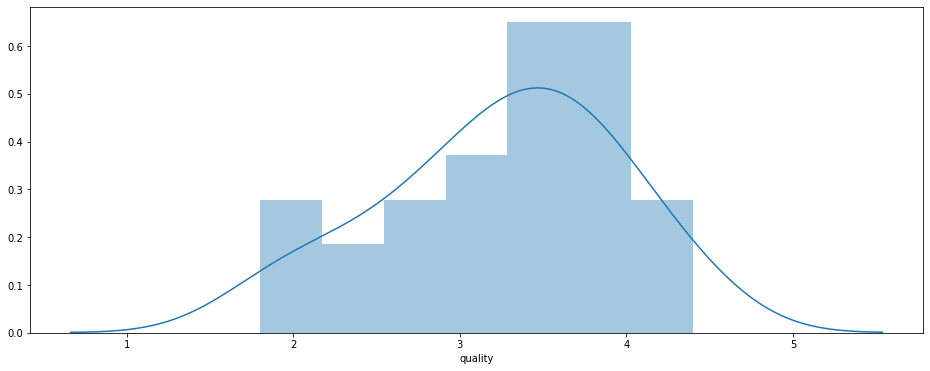

In [20]:
sns.distplot(econ_stats_df.quality, bins = 7)

For the most part, it looks like **professor's overall quality is normally distributed**. One approach to selecting good professors could be to **take the professors that have a quality of at least one standard deviation above the mean quality**. Approximately, this should be the professors in the 70th percentile.

In [21]:
print('Mean quality:', econ_stats_df.quality.mean())
print('SD of quality:',econ_stats_df.quality.std())

Mean quality: 3.2517241379310344
SD of quality: 0.7013358119918489


In [22]:
econ_stats_df[econ_stats_df.quality >= econ_stats_df.quality.mean() + econ_stats_df.quality.std()]

,name,quality,difficulty,take_again,num_ratings,top_tags
0,EthanAnderes,4.3,2.6,100%,76.0,"[Caring, Respected, Clear grading criteria, Am..."
26,DerekStimel,4.3,3.1,89%,54.0,"[Amazing lectures, Accessible outside class, C..."
27,JanineWilson,4.4,3.0,82%,122.0,"[Amazing lectures, Skip class? You won't pass...."


After filtering out for good professors, we're unfortunately left with **just 3 professors**, which is definitely not enough to make any meaningful insights. What should we do next?

Fortunately, RMP has a list (shown below) of all professors where you can sort by "most rated." On top of that, RMP conveniently mentions that the true average quality for a professor is 3.75. We can take a shortcut by **taking *some* of the highly (number) rated professors who have an overall quality of at least one standard deviation above the mean**.

**Note:** We will also use the (sample) standard deviation from our previous sample as a rough estimate for the population of professors at UC Davis.

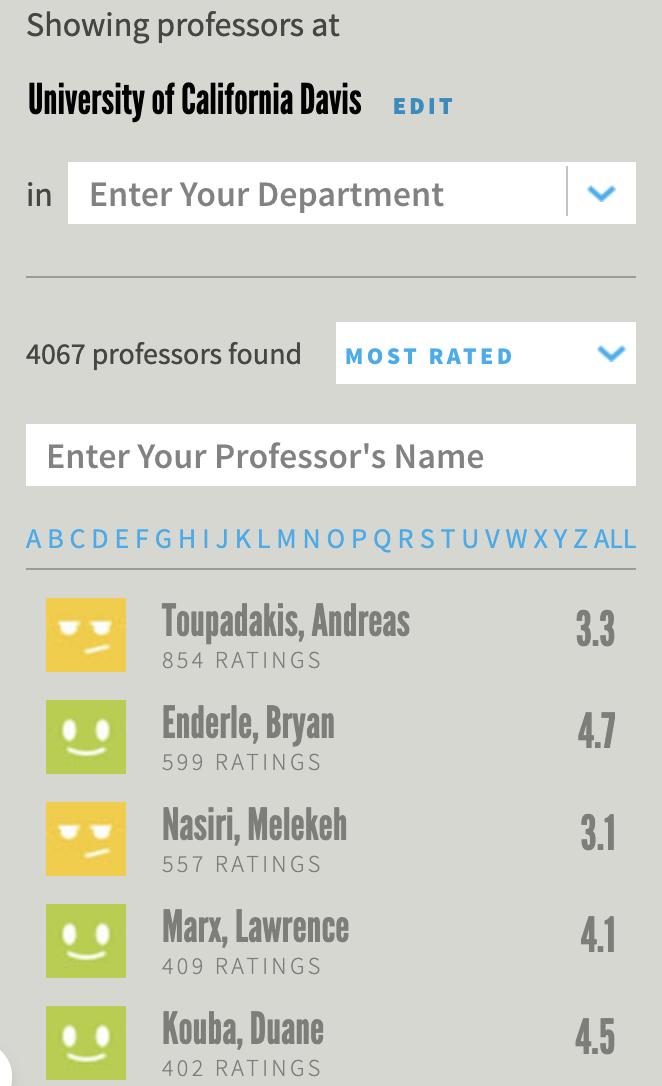

In [23]:
Image.open('/Users/tylerchang/Desktop/ratemyprof/images/most_rated.png')

In [24]:
sigma_hat = econ_stats_df.quality.std()
cutoff = 3.75 + econ_stats_df.quality.std()
cutoff

4.451335811991849

In [25]:
good_urls = ['https://www.ratemyprofessors.com/ShowRatings.jsp?tid=81946',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=58847',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=674373',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1805461',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=314969',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1199036',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=78075',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=24184',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=104898',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=682666',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1656889',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=13481',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=661326',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=139528',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=925885',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=151500',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1228644',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=148799',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=109831',
             'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=630818']

In [27]:
good_profs = getProfs(good_urls)
good_profs.head()

,name,quality,difficulty,take_again,num_ratings,top_tags
0,BryanEnderle,4.7,3.2,95%,600.0,"[Amazing lectures, Respected, Hilarious, Inspi..."
1,DuaneKouba,4.5,3.0,94%,402.0,"[Respected, Amazing lectures, Accessible outsi..."
2,WalterLeal,4.5,2.7,90%,281.0,"[Respected, Caring, Skip class? You won't pass..."
3,WilliamTavernetti,4.8,3.0,91%,270.0,"[Inspirational, Amazing lectures, Respected, C..."
4,EvaSchepeler,4.6,2.8,94%,197.0,"[EXTRA CREDIT, Amazing lectures, Respected, Ge..."


Now that we finally have a reasonable sample of good professors, we can start looking at what students look for in a good professor. Let's start by looking at the `top_tags` feature. At the end of filling out a review, the user has the opportunity on selecting from a number of tags that they feel describes the professor. Conveniently, RMP tells us which were the "top tags" used for a given professor.

In [28]:
top = []
for i in range(0, len(good_profs)):
    top.append(good_profs.top_tags[i])
top = [j for i in top for j in i]
Counter(top).most_common(10)

[('Respected', 16),
 ('Amazing lectures', 14),
 ('Inspirational', 10),
 ('Hilarious', 8),
 ('Caring', 8),
 ("Skip class? You won't pass.", 6),
 ('Tough grader', 4),
 ('Clear grading criteria', 4),
 ('Would take again', 4),
 ('Accessible outside class', 3)]

Here we compiled a dictionary of the top tags used for all of the good professors, along with their counts. From this, we can see that **students potentially put high value on the personality of a professor**. Notice that 4 of the top 5 seen tags have to do solely on personality (i.e. `Respected`, `Inspirational`, `Hilarious`, `Caring`), while only one of those tags actually is related to teaching style. 

Similar to the previous section, we can gather the recent reviews for these good professors and find the words commonly used to describe them!

In [29]:
corpus_list = [getText(x) for x in good_urls]
corpus_df = pd.DataFrame({'name':good_profs.name, 'corpus':corpus_list})
clean_df = pd.DataFrame({'name':good_profs.name, 'clean_corpus':corpus_df.corpus.apply(cleaner)})
big_corpus = ' '.join(clean_df.clean_corpus)
big_corpus

'enderle is really the best for  series no one else can explainteach chem as clear and understandable as him he provides so many resources to help you youtube vids readers practice exams extra credit oh but ultimately its up to you to take advantage of them definitely thankful for him and wished he taught ochem i found myself excited to get up for enderles  am lectures because i knew i was getting the best education possible with this guy super caring funny and clear lecturer does demos almost every day in class also the book of practice tests you can buy is filled with his old tests so they exactly mimic the tests you take in class enderle is by far one of the best professors at davis his lectures are very clear and he provides students with tons of resources for practice his  readers were extremely helpful his class gives you a good foundation for future chem classes  would recommend amazing he is seriously the best professor i have ever had he made me excited about chem and explaine

In this step, I grabbed the reviews for the good professors and combined them into one huge string so we can count the words within the string. I will skip creating the document-term matrix again and go straight into visualizing the result with more WordClouds!

Text(0.5, 1.0, 'The Good Professor')

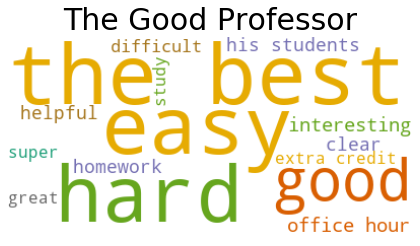

In [30]:
more_stop_words = ['class', 'professor', 'lecture', 'exam', 'really', 'lecture', 'test', 'tests','hes', 'dr', 'midterm',
                  'just', 'ive', 'question', 'are', 'like', 'lectures','make','grade','student','time','work','material',
                  'final','took']
stop_words = text.ENGLISH_STOP_WORDS.union(more_stop_words)

wc = WordCloud(stopwords = stop_words, background_color = 'white', colormap = 'Dark2',
              max_font_size = 150, random_state = 42, max_words=15)

plt.rcParams['figure.figsize'] = [16,6]

plt.subplot(1, 2, 1)
wc.generate(big_corpus)
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")
plt.title('The Good Professor', fontsize= 30)

Here we can see a slight deviation from our previous finding when looking at the `top_tags` feature. Based on token frequency, it appears that **students also value teaching style**, with words like 'clear' and 'helpful' being prevalent. We can also see that **students may actually be valuing quality over easiness**. There's a good mix of words like "easy" and "hard", "helpful" and "difficult", and words that indicate that you still have to do work to succeed like "study", "homework", etc..

### Q3: What is the overall sentiment across the UC Davis Statistics and Economics Departments?

Graduating with a double major in Statistics and Economics, I was lucky enough to have the opportunity to learn under two of the world class departments. In this section, I want to dive into the overall nature of the reviews in both departments. **Are the reviews more positive or negative in tone? Do students tend to be subjective or objective when reviewing their teachers? How do we par with other schools in the UC system?**

Let's start by looking at the sentiment at the Economics Department.

In [31]:
econ_df = getReviews(econ_urls)
econ_df.head()

,name,text,Attendance,Grade,Online Class,Textbook,Would Take Again,For Credit,quality,difficulty,polarity,subjectivity,character_length
0,Paul Bergin,He is the best professor ever that I met durin...,Not Mandatory,NaN,NaN,No,Yes,Yes,5.0,4.0,0.516667,0.416667,193
1,Paul Bergin,This course is not easy but you can get a good...,Not Mandatory,A+,NaN,No,Yes,Yes,5.0,3.0,0.142708,0.695833,157
2,Paul Bergin,"His lectures are somewhat dry, but he's a good...",Not Mandatory,A+,Yes,Yes,Yes,Yes,4.0,2.0,0.177778,0.466667,231
3,Paul Bergin,"Paul is a concise and knowledgable lecturer, b...",Mandatory,A-,NaN,Yes,No,Yes,4.0,4.0,-0.126190,0.673810,342
4,Paul Bergin,The 4 grading schemes he uses is built to bene...,NaN,B,NaN,Yes,Yes,Yes,4.0,5.0,0.208333,0.586667,330


With this, we want to pay special attention to the polarity and subjectivity features. A review's **polarity** $[-1, 1]$ is a measure of how positive or negative in tone it is. **Subjectivity** $[0, 1]$ is a measure of how subjective or objective the review is. For more details on specific calculations, please check the [`TextBlob documentation`](https://textblob.readthedocs.io/en/dev/). Let's take a look at a couple of these reviews to get a feel for these features.

In [32]:
print('Polarity:', econ_df.polarity[286])
print(econ_df.text[296])

Polarity: -0.8499999999999999
handwriting on tablet was awful. Using a tablet for teaching 102 was clunky. Tough to understand and awful at explaining the material.


This is an example of a **negative (low polarity) review**. As you can see the student here isn't too happy with this professor.

In [33]:
print('Polarity:', econ_df.polarity[26])
print(econ_df.text[26])

Polarity: 0.6875
Prof. Boik is one of my favorite professors at UCD. He gives good lectures and provide helpful slides. To do well in his class, just do all the practice exams that he provides!


This is an example of a **positive (high polarity) review**. The student's tone is drastically more positive than the previous one.

In [34]:
print('Subjectivity:', econ_df.subjectivity[375])
print(econ_df.text[375])

Subjectivity: 0.0
His lectures are informative but the tests are way harder than his lectures. Lots of homework. The homework ruined the class for me. Tests way harder than the practice tests. Read and do ATPs if you want to do well.


This is an example of an **objective (low subjectivity) review**. Notice that this review seems like the students is speaking purely from observation here. 

In [35]:
print('Subjectivity:', econ_df.subjectivity[375])
print(econ_df.text[226])

Subjectivity: 0.0
Excellent professor! Very nice and caring. His class consisted of one midterm (either 40 or 45% of your grade) and a final (either 60% or 55% of your grade), which sounds scary but it's not! He posts practice problem sets that you can go through and practice exams which do closely mirror the exams, he's not a fan of throwing curveballs on exams!


This is an example of a **subjective (high subjectivity) review**. It seems like the student is speaking mostly from personal experience here.

Now that we have a better understanding of what these features mean, we can now take a look at their distributions along with some summary statistics.

Mean polarity: 0.12401642904719665


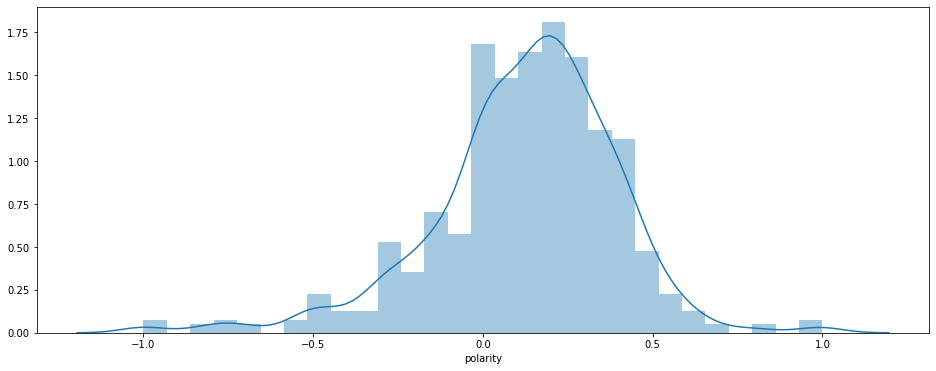

In [36]:
print('Mean polarity:', econ_df['polarity'].mean())
sns.distplot(econ_df.polarity)

Mean subjectivity: 0.5743044057023798


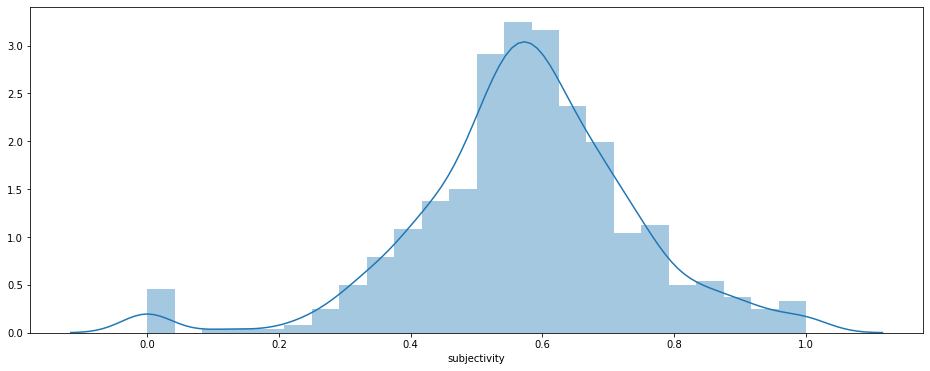

In [37]:
print('Mean subjectivity:', econ_df['subjectivity'].mean())
sns.distplot(econ_df.subjectivity)

It looks like both the polarity and subjectivity of reviews are approximately normally distributed. The mean polarity is approximately 0.12, meaning that **(on average) the reviews are just slightly positive for these professors**. The mean subjectivity is approximately 0.57, which implies that **(on average) the reviews are slightly subjective**.

Now that we have a good idea of the sentiment across the Economics department, we can now compare this result to that of the Statistics department. **Does one department get a "better" sentiment than the other?**

In [38]:
stats_df = getReviews(stats_urls)
stats_df.head()

,name,text,Attendance,Grade,Online Class,Textbook,Would Take Again,For Credit,quality,difficulty,polarity,subjectivity,character_length
0,Ethan Anderes,He's a really nice guy who wants you to the le...,Not Mandatory,A,NaN,No,Yes,Yes,5.0,4.0,0.240625,0.653125,341
1,Ethan Anderes,He really wants his students to understand the...,Not Mandatory,A+,NaN,No,Yes,Yes,5.0,3.0,0.410000,0.533333,235
2,Ethan Anderes,Seriously one of the nicest profs I've taken. ...,Not Mandatory,A,NaN,No,Yes,Yes,5.0,2.0,0.054563,0.459325,337
3,Ethan Anderes,"Great Professor. 3 midterms, 12 questions each...",Not Mandatory,A-,NaN,No,Yes,Yes,5.0,3.0,0.266667,0.916667,203
4,Ethan Anderes,"Not only is he cute, but he also loved us clea...",Not Mandatory,NaN,NaN,No,Yes,Yes,5.0,3.0,0.227778,0.742593,343


Mean polarity: 0.08872670933452158


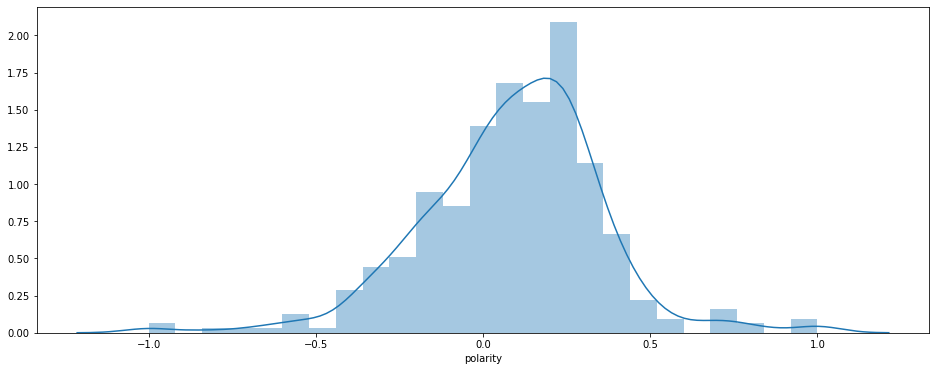

In [39]:
print('Mean polarity:', stats_df['polarity'].mean())
sns.distplot(stats_df.polarity)

Mean subjectivity: 0.592540017542012


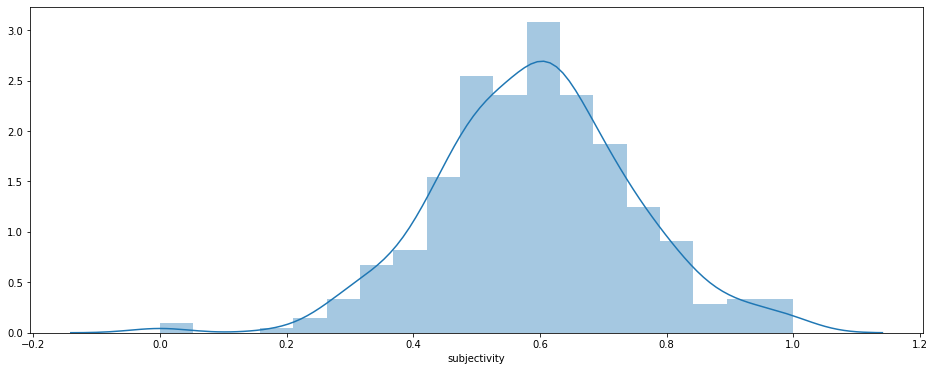

In [40]:
print('Mean subjectivity:', stats_df['subjectivity'].mean())
sns.distplot(stats_df.subjectivity)

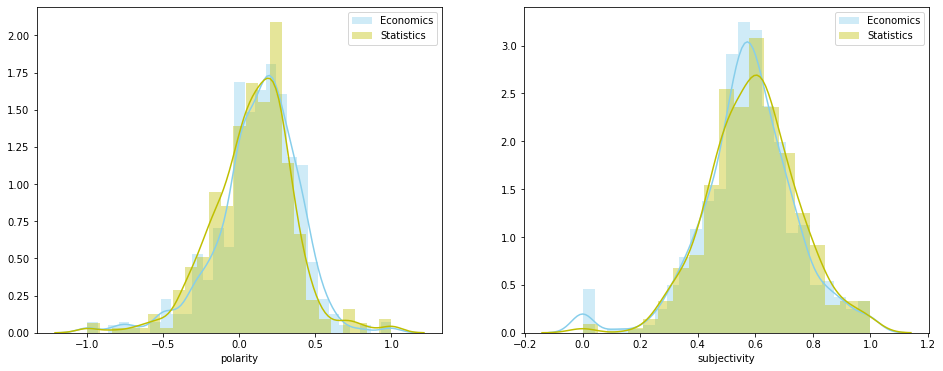

In [41]:
plt.subplot(1, 2, 1)
sns.distplot(econ_df['polarity'], color = "skyblue", label = "Economics")
sns.distplot(stats_df['polarity'], color = "y", label = "Statistics")
plt.legend()

plt.subplot(1, 2, 2)
sns.distplot(econ_df['subjectivity'], color = "skyblue", label = "Economics")
sns.distplot(stats_df['subjectivity'], color = "y", label = "Statistics")
plt.legend()

It looks like the distributions of polarity and subjectivity are the same across the departments, and both departments have approximately equal centers. That is, **there is no one department that does "better" in sentiment than the other.**

We can take this sentiment analysis one step further, by **comparing the sentiment of these particular departments across other schools in the UC system**.

### UC Irvine

In [42]:
uci_stats_urls = ['https://www.ratemyprofessors.com/ShowRatings.jsp?tid=268471',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2587150',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2549322',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=636382',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=813268',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1784613',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1275967',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2236104',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1139474',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1338856',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1004180',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1148244',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=13201',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=968241',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=340293',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2454191',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2285930']

uci_econ_urls = ['https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2498782',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=238482',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=601875',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=770325',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1697119',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=813276',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2423106',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2186704',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1885846',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2117143',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2240210',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=308558',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2454191',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=424564',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=142714',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=361539',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=288026',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2263098',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=177413',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=774965',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=822785',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=217367',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1209998',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2266977',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=163553',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1987538']

uci_stats = getReviews(uci_stats_urls)
uci_econ = getReviews(uci_econ_urls)

### UC Berkeley

In [43]:
ucb_stats_urls = ['https://www.ratemyprofessors.com/ShowRatings.jsp?tid=124596',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=578522&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1561704&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=838566&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2464203&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=832399&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1676551&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2475544&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2600931&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2128084&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=855080&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=318823&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=521380&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1256749&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=558447&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1980208&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2498757&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1346314&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1294058&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1126010&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1381397&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2330004&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2586040&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=526869&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1824040&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=211950&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2576290&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2141144&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1052288&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1512401&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=11539&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=244354&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1478882&showMyProfs=true',
                 'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=654882&showMyProfs=true']

ucb_econ_urls = ['https://www.ratemyprofessors.com/ShowRatings.jsp?tid=625491',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=422757',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1082170',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=389870',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2467136',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1568140',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2486709',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2243159',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1113014',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=946042',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=161938',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1011629',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2346217',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2594177',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=803766',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=509423',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2504392',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=101785',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2386826',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=585658',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2094015',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=509426',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=38534',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=318112',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=852166',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=1867393',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2516822',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2388707',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2344295',
                'https://www.ratemyprofessors.com/ShowRatings.jsp?tid=2115934']

ucb_stats = getReviews(ucb_stats_urls)
ucb_econ = getReviews(ucb_econ_urls)

Economics Departments Average Subjectivity
UC Davis: 0.5743044057023798
UC Irvine: 0.5836412483073685
UC Berkeley: 0.5693930553024992 

Statistics Departments Average Subjectivity
UC Davis: 0.592540017542012
UC Irvine: 0.5715954819704369
UC Berkeley: 0.5823157432508049 

Economics Departments Average Polarity
UC Davis: 0.12401642904719665
UC Irvine: 0.05753813300862713
UC Berkeley: 0.157924843180178 

Statistics Departments Average Polarity
UC Davis: 0.08872670933452158
UC Irvine: 0.09329703469186973
UC Berkeley: 0.0627974647092379


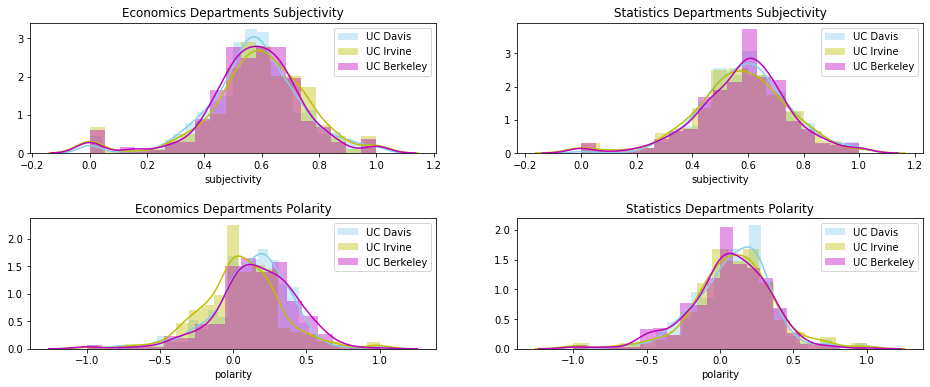

In [44]:
fig = plt.figure()
fig.subplots_adjust(hspace=.5)

# Distribution of subjectivity (Econ)
plt.subplot(2, 2, 1)
sns.distplot(econ_df['subjectivity'], color = "skyblue", label = "UC Davis")
sns.distplot(uci_econ['subjectivity'], color = "y", label = "UC Irvine")
sns.distplot(ucb_econ['subjectivity'], color = "m", label = "UC Berkeley")
plt.title("Economics Departments Subjectivity")
plt.legend()

# Distribution of subjectivity (Stats)
plt.subplot(2, 2, 2)
sns.distplot(stats_df['subjectivity'], color = "skyblue", label = "UC Davis")
sns.distplot(uci_stats['subjectivity'], color = "y", label = "UC Irvine")
sns.distplot(ucb_stats['subjectivity'], color = "m", label = "UC Berkeley")
plt.title('Statistics Departments Subjectivity')
plt.legend()

# Distribution of polarity (Econ)
plt.subplot(2, 2, 3)
sns.distplot(econ_df['polarity'], color = "skyblue", label = "UC Davis")
sns.distplot(uci_econ['polarity'], color = "y", label = "UC Irvine")
sns.distplot(ucb_econ['polarity'], color = "m", label = "UC Berkeley")
plt.title("Economics Departments Polarity")
plt.legend()

# Distribution of polarity (Stats)
plt.subplot(2, 2, 4)
sns.distplot(stats_df['polarity'], color = "skyblue", label = "UC Davis")
sns.distplot(uci_stats['polarity'], color = "y", label = "UC Irvine")
sns.distplot(ucb_stats['polarity'], color = "m", label = "UC Berkeley")
plt.title('Statistics Departments Polarity')
plt.legend()

print('Economics Departments Average Subjectivity')
print('UC Davis:', econ_df.subjectivity.mean())
print('UC Irvine:', uci_econ.subjectivity.mean())
print('UC Berkeley:', ucb_econ.subjectivity.mean(), '\n')

print('Statistics Departments Average Subjectivity')
print('UC Davis:', stats_df.subjectivity.mean())
print('UC Irvine:', uci_stats.subjectivity.mean())
print('UC Berkeley:', ucb_stats.subjectivity.mean(), '\n')

print('Economics Departments Average Polarity')
print('UC Davis:', econ_df.polarity.mean())
print('UC Irvine:', uci_econ.polarity.mean())
print('UC Berkeley:', ucb_econ.polarity.mean(), '\n')

print('Statistics Departments Average Polarity')
print('UC Davis:', stats_df.polarity.mean())
print('UC Irvine:', uci_stats.polarity.mean())
print('UC Berkeley:', ucb_stats.polarity.mean())

It looks like **all of the schools sentiment are all distributed (approximately) equally**. Particularly looking at polarity, it appears that there is no one school that gets significantly more positive reviews than the other.

**Note:** I used UC Irvine and UC Berkeley, but I did look into all of the other schools in the UC system. It turns out that all of the other UC's had a very sparse amount of reviews for the professors in this department. Notably, UC Davis had the most reviews of the three.

## Part 4: Classification

The purpose of this next section is to develop a model that can **classify the quality of a review solely based on its contents**. For this part, we will create a model that can determine if the review is **Awesome** $(q \in [4,5])$, **Okay** $(q \in (2,4))$, or **Awful** $(q \in [1,2])$ using all of the reviews we have 

In [54]:
urls = econ_urls + stats_urls + uci_stats_urls + uci_econ_urls + ucb_stats_urls + ucb_econ_urls 
allSchools = getReviews(urls)
allSchools.head()

,name,text,Attendance,Grade,Online Class,Textbook,Would Take Again,For Credit,quality,difficulty,polarity,subjectivity,character_length
0,Paul Bergin,He is the best professor ever that I met durin...,Not Mandatory,NaN,NaN,No,Yes,Yes,5.0,4.0,0.516667,0.416667,193
1,Paul Bergin,This course is not easy but you can get a good...,Not Mandatory,A+,NaN,No,Yes,Yes,5.0,3.0,0.142708,0.695833,157
2,Paul Bergin,"His lectures are somewhat dry, but he's a good...",Not Mandatory,A+,Yes,Yes,Yes,Yes,4.0,2.0,0.177778,0.466667,231
3,Paul Bergin,"Paul is a concise and knowledgable lecturer, b...",Mandatory,A-,NaN,Yes,No,Yes,4.0,4.0,-0.126190,0.673810,342
4,Paul Bergin,The 4 grading schemes he uses is built to bene...,NaN,B,NaN,Yes,Yes,Yes,4.0,5.0,0.208333,0.586667,330


### Data Cleaning

There are a couple of features that we will remove: **Online Class, Textbook, and For Credit**. These features probably won't have much of an effect on whether the user's perception of quality. We can also take out **Name and Text** since these basically serve as indices for each review.

In [56]:
allSchools = allSchools.drop(columns = ['name','text','Online Class', 'Textbook', 'For Credit'])
allSchools

,Attendance,Grade,Would Take Again,quality,difficulty,polarity,subjectivity,character_length
0,Not Mandatory,NaN,Yes,5.0,4.0,0.516667,0.416667,193
1,Not Mandatory,A+,Yes,5.0,3.0,0.142708,0.695833,157
2,Not Mandatory,A+,Yes,4.0,2.0,0.177778,0.466667,231
3,Mandatory,A-,No,4.0,4.0,-0.126190,0.673810,342
4,NaN,B,Yes,4.0,5.0,0.208333,0.586667,330
...,...,...,...,...,...,...,...,...
2177,Not Mandatory,A-,Yes,4.0,2.0,0.140000,0.540000,349
2178,Not Mandatory,A+,Yes,5.0,3.0,0.324643,0.579762,231
2179,Mandatory,NaN,No,3.0,5.0,0.006667,0.540000,321
2180,NaN,NaN,Yes,5.0,3.0,0.505469,0.712500,270


Another feature I considered dropping was **Attendance**. This feature wasn't as obvious to me whether or not it could have an effect on how the user views the professor's quality, so I took a deeper look into the distribution between professors with **mandatory** attendance and **non-mandatory** attendance.

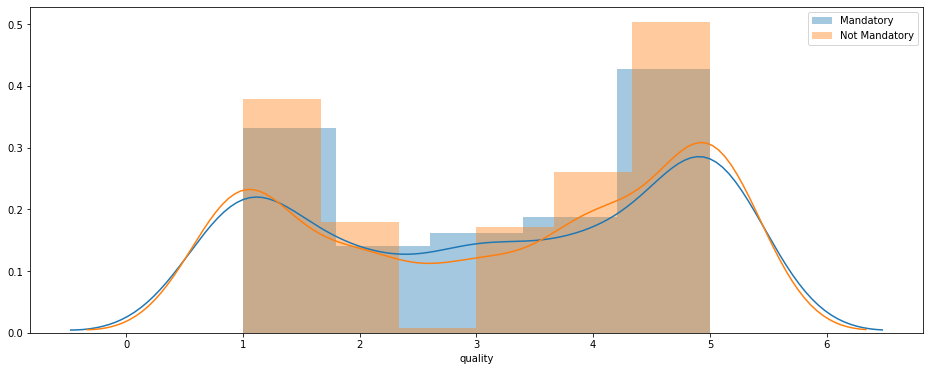

In [57]:
mandatory = allSchools[allSchools.Attendance == 'Mandatory']
not_mandatory = allSchools[allSchools.Attendance == 'Not Mandatory']

sns.distplot(mandatory.quality, label = "Mandatory")
sns.distplot(not_mandatory.quality, label = "Not Mandatory")
plt.legend()

Here it looks like the distribution of quality is approximately the same across both groups. That is, **attendance shouldn't be too valuable in distinguishing the rating quality.**

In [58]:
allSchools = allSchools.drop(columns = ['Attendance'])
allSchools.head()

,Grade,Would Take Again,quality,difficulty,polarity,subjectivity,character_length
0,NaN,Yes,5.0,4.0,0.516667,0.416667,193
1,A+,Yes,5.0,3.0,0.142708,0.695833,157
2,A+,Yes,4.0,2.0,0.177778,0.466667,231
3,A-,No,4.0,4.0,-0.126190,0.673810,342
4,B,Yes,4.0,5.0,0.208333,0.586667,330


### Dealing With Missing Values

Now that we have filtered out some features, we should now take a **look at the missing values in the data set**.

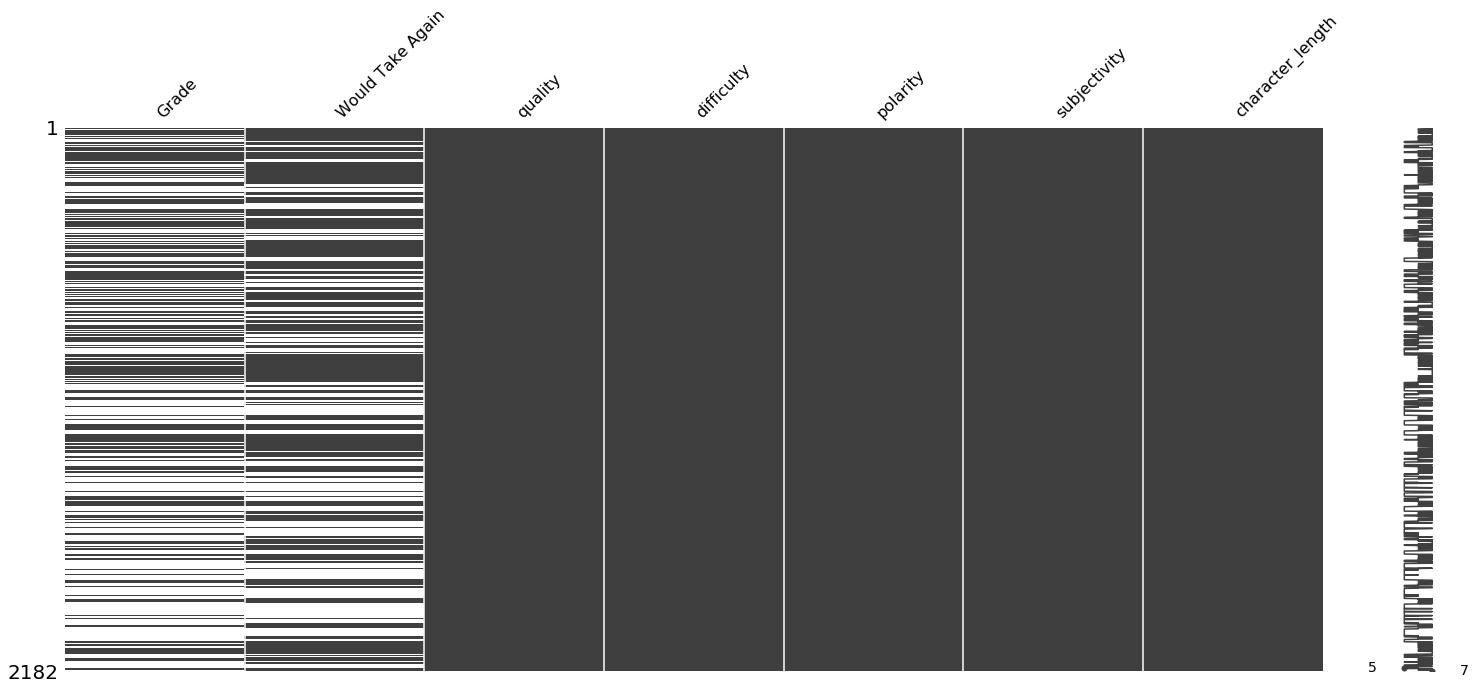

In [59]:
missingno.matrix(allSchools)

It looks like the **Grade and Would Take Again** features have a lot of missing values. We definitely do not want to just remove the rows that have some kind of missing values. These features seem like they would be very important to how the user perceives their professor.

In [60]:
allSchools.Grade.value_counts(dropna = False)

NaN                1210
A                   295
Not sure yet        145
A-                  112
A+                  101
B+                   82
B                    76
B-                   34
Rather not say       31
C+                   22
C                    17
Not_Sure_Yet         11
C-                    9
Incomplete            9
Drop/Withdrawal       8
D                     5
D+                    4
Rather_Not_Say        3
F                     3
Audit/No Grade        3
D-                    2
Name: Grade, dtype: int64

Not only is there many different possible letter grades, but there are quite a few different options like "Incomplete", "Rather Not Say", etc., that we have to deal with also. 

Let's first deal with these non-letter grade options first. We'll get rid of the options **Audit/No Grade** and **Drop/Withdrawal** since the user never actually received a grade for the class.

In [100]:
subset = allSchools[(allSchools.Grade != 'Audit/No Grade') & (allSchools.Grade != 'Drop/Withdrawal')].reset_index(drop = True)
subset.head()

,Grade,Would Take Again,quality,difficulty,polarity,subjectivity,character_length
0,NaN,Yes,5.0,4.0,0.516667,0.416667,193
1,A+,Yes,5.0,3.0,0.142708,0.695833,157
2,A+,Yes,4.0,2.0,0.177778,0.466667,231
3,A-,No,4.0,4.0,-0.126190,0.673810,342
4,B,Yes,4.0,5.0,0.208333,0.586667,330


With the ratings that have a letter grade, we'll just simply **label them as either a "good" grade or "bad" grade**. This will help when we have to impute the ratings that have different values for Grade.

In [101]:
good_grade = ['A', 'A-', 'A+', 'B', 'B-', 'B+']
bad_grade = ['F', 'D-', 'D+', 'C', 'C-', 'C+']

Next, we need to figure out how to fill out the other options as well as the null values. Since we already labeled the letter grades as "good" or "bad", we need to label the remaining options the same way. One approach to doing this is by looking at the **polarity** of the review. If the user had a positive-toned review, we will label it as "good", if the user had a negative-toned review, we will label it as "bad."

In [102]:
new_grades = []
for index, row in subset.iterrows():
    if subset.iloc[index, 2] in good_grade:
        new_grades.append('Good')
    elif subset.iloc[index, 2] in bad_grade:
        new_grades.append('Bad')
    else:
        if subset.iloc[index, 4] >= 0:
            new_grades.append('Good')
        else:
            new_grades.append('Bad')
subset['new_grades'] = new_grades
subset.head()

,Grade,Would Take Again,quality,difficulty,polarity,subjectivity,character_length,new_grades
0,NaN,Yes,5.0,4.0,0.516667,0.416667,193,Good
1,A+,Yes,5.0,3.0,0.142708,0.695833,157,Good
2,A+,Yes,4.0,2.0,0.177778,0.466667,231,Good
3,A-,No,4.0,4.0,-0.126190,0.673810,342,Bad
4,B,Yes,4.0,5.0,0.208333,0.586667,330,Good


In [103]:
subset['new_grades'].value_counts(dropna =False)

Good    1526
Bad      645
Name: new_grades, dtype: int64

We'll fill the **Would Take Again** feature based on **polarity** as well.

In [104]:
empty_idx = []
for index, row in subset.iterrows():
    if isinstance(row['Would Take Again'], float):
        empty_idx.append(index)
    else:
        continue

for index in empty_idx:
    if subset.iloc[index, 4] >= 0:
        subset.iloc[index, 1] = 'Yes'
    else:
        subset.iloc[index, 1] = 'No' 

In [105]:
subset['Would Take Again'].value_counts(dropna =False)

Yes    1338
No      833
Name: Would Take Again, dtype: int64

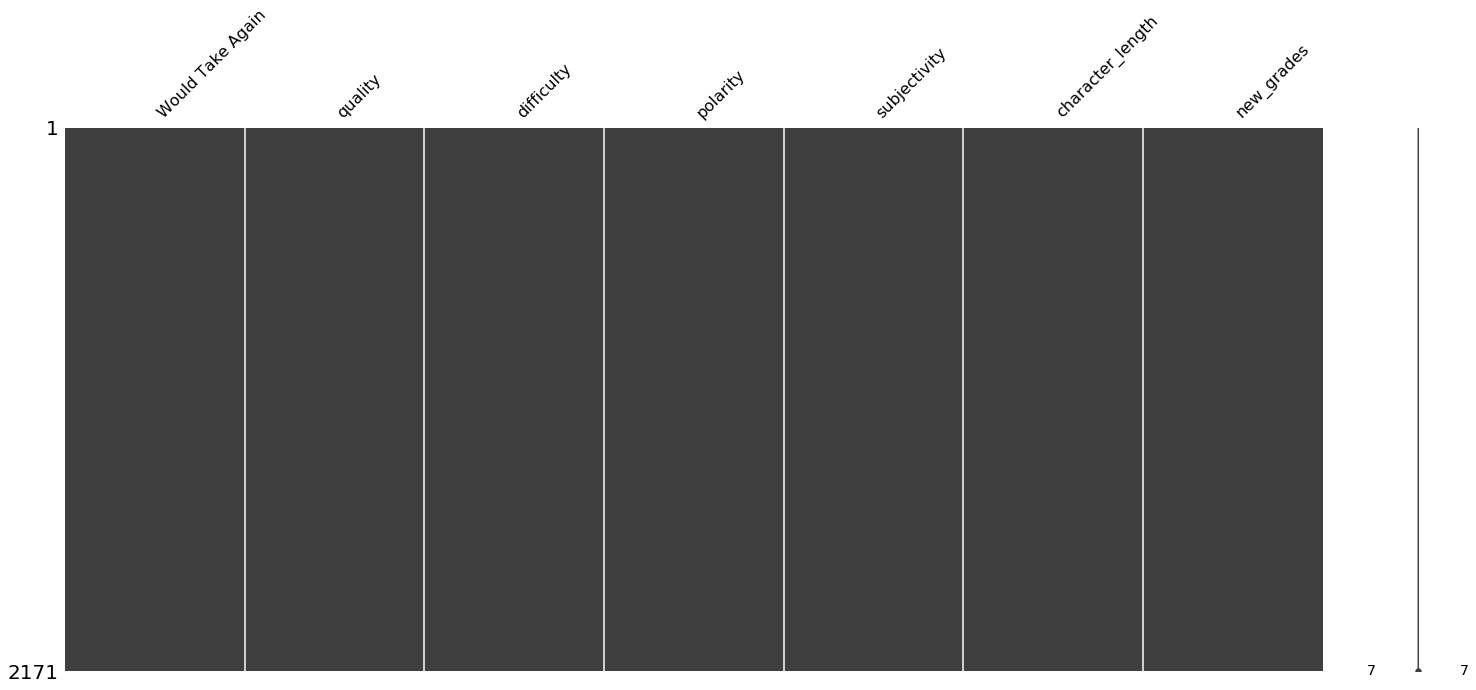

In [106]:
subset = subset.drop(columns = ['Grade'])
missingno.matrix(subset)

Now that we have our feature matrix, ready to go, let's quickly create our **target feature**.

In [107]:
new_quality = []

# for quality in subset.quality:
#     if quality <= 2:
#         new_quality.append('Awful')
#     elif 2 < quality < 4:
#         new_quality.append('Okay')
#     else:
#         new_quality.append('Awesome')
        
for quality in subset.quality:
    if quality <= 2.5:
        new_quality.append('Awful')
    else:
        new_quality.append('Awesome')


subset['new_quality'] = new_quality
subset = subset.drop(columns = ['quality'])
subset.head()

,Would Take Again,difficulty,polarity,subjectivity,character_length,new_grades,new_quality
0,Yes,4.0,0.516667,0.416667,193,Good,Awesome
1,Yes,3.0,0.142708,0.695833,157,Good,Awesome
2,Yes,2.0,0.177778,0.466667,231,Good,Awesome
3,No,4.0,-0.126190,0.673810,342,Bad,Awesome
4,Yes,5.0,0.208333,0.586667,330,Good,Awesome


### Model Fitting

In [108]:
X = subset.iloc[:,0:6]
y = subset.new_quality

In [116]:
def runModel(model, X, y):
    column_trans = make_column_transformer(
        (OneHotEncoder(), ['Would Take Again', 'new_grades','difficulty']),
        remainder = 'passthrough')
    pipe = make_pipeline(column_trans, model)
    accuracy = cross_val_score(pipe, X, y, cv = 10, scoring = 'accuracy').mean()
    return accuracy

### Logistic Regression

In [117]:
runModel(LogisticRegression(), X, y)

0.8410666723037247

### Gradient Boosting Classifier

In [122]:
runModel(GradientBoostingClassifier(), X, y)

0.8387667526318016

### Gaussian Naive Bayes 

In [118]:
runModel(GaussianNB(), X, y)

0.8240265505432716

### K-Nearest Neighbors

In [124]:
runModel(KNeighborsClassifier(), X, y)

0.7788758297044772

### Linear Support Vector Classifier

In [123]:
runModel(LinearSVC(), X, y)

0.7701348666131147

### Decision Tree Classifier

In [125]:
runModel(DecisionTreeClassifier(), X, y)

0.7600093011457321

### Stochastic Gradient Descent

In [121]:
runModel(SGDClassifier(), X, y)

0.7563755126199636

It looks like **Logistic Regression performed the best** in terms of classification. 